In [1]:
from rdkit import Chem
from rdkit.Chem import CanonSmiles, Draw, MolFromSmiles
from rdkit.Chem.rdmolops import RDKFingerprint
from rdkit.DataStructs.cDataStructs import BulkTanimotoSimilarity
import torch

from coati.generative.coati_purifications import embed_smiles
from coati.models.io.coati import load_e3gnn_smiles_clip_e2e
from coati.models.simple_coati2.io import load_coati2

# Model parameters are pulled from the url and stored in a local models/ dir
# By default, this is using the CPU -- to use a GPU, comment/uncomment the relevant lines below

encoder1, tokenizer1 = load_e3gnn_smiles_clip_e2e(
    freeze=True,
    # device=torch.device("cuda:0"), # USE FOR GPU
    device="cpu", # USE FOR CPU
    # model parameters to load.
    doc_url="s3://terray-public/models/barlow_closed.pkl",
)

encoder2, tokenizer2 = load_coati2(
    freeze=True,
    # device=torch.device("cuda:0"), # USE FOR GPU
    device="cpu", # USE FOR CPU
    force_cpu=True, # USE FOR CPU
    # model parameters to load.
    doc_url="s3://terray-public/models/coati2_chiral_03-08-24.pkl",
)

# Function to run unconditional generation from a single SMILES
def gen_mol(smiles, coati_version = 1, num_variations = 100, noise_scale = 0.15):

    # Embed the SMILES
    smiles = CanonSmiles(smiles)
    if coati_version == 1:
        vector = embed_smiles(smiles, encoder1, tokenizer1)
    elif coati_version == 2:
        vector = embed_smiles(smiles, encoder2, tokenizer2)

    # Noise is added as an isotropic Gaussian with std=noise_scale
    if coati_version == 1:
        nearby_smiles = encoder1.hclip_to_2d_batch(
            h_clip=vector.unsqueeze(0).repeat(num_variations, 1),
            tokenizer=tokenizer1,
            noise_scale=noise_scale,
        )
    elif coati_version == 2:
        nearby_smiles = encoder2.hcoati_to_2d_batch(
            h_coati=vector.unsqueeze(0).repeat(num_variations, 1),
            tokenizer=tokenizer2,
            noise_scale=noise_scale,
        )

    unique_valid_smiles = list(set([CanonSmiles(smi) for smi in nearby_smiles if MolFromSmiles(smi)]))
    had_orig = smiles in unique_valid_smiles
    unique_valid_smiles = list(set([smiles] + unique_valid_smiles))
    fp = RDKFingerprint(MolFromSmiles(smiles), minPath=1, maxPath=7, fpSize=2048)
    fps = [RDKFingerprint(MolFromSmiles(x), minPath=1, maxPath=7, fpSize=2048) for x in unique_valid_smiles]
    sim = BulkTanimotoSimilarity(fp, fps)
    sim_str = [str(round(x, 2)) for x in sim]
    unique_valid_smiles, sim_str = zip(*sorted(zip(unique_valid_smiles, sim_str), key=lambda x:x[1], reverse=True))
    if not had_orig:
        unique_valid_smiles, sim_str = zip(*[[i, f"{j} (Added)"] if i==smiles else [i, j] for i, j in zip(unique_valid_smiles, sim_str)])
    print (f"Attempted {num_variations} COATI{coati_version} generations with a noise scale of {noise_scale} and generated {len(unique_valid_smiles)} unique structures.")
    display(Draw.MolsToGridImage([MolFromSmiles(s) for s in unique_valid_smiles], molsPerRow=5, subImgSize=(200, 200), maxMols=100, legends=sim_str))
    return unique_valid_smiles

Loading model from s3://terray-public/models/barlow_closed.pkl
Loading tokenizer may_closedparen from s3://terray-public/models/barlow_closed.pkl
number of parameters: 12.64M
number of parameters Total: 2.44M xformer: 17.92M Total: 20.36M 
vocab_name not found in tokenizer_vocabs, trying to load from file
Freezing encoder
20561664 params frozen!
Loading model from s3://terray-public/models/coati2_chiral_03-08-24.pkl
Loading tokenizer coati2_12_12 from s3://terray-public/models/coati2_chiral_03-08-24.pkl
number of parameters: 50.44M
number of parameters Total: xformer: 54.81M 
vocab_name not found in tokenizer_vocabs, trying to load from file
Freezing encoder
56385536 params frozen!


# Input a SMILES string

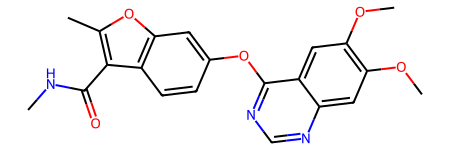

In [3]:
smiles_str = "CC1=C(C2=C(O1)C=C(C=C2)OC3=NC=NC4=CC(=C(C=C43)OC)OC)C(=O)NC"
# This is fruquintinib (Takeda); got it from https://drughunter.com/articles/2023-novel-small-molecule-fda-drug-approvals/
MolFromSmiles(smiles_str)

### 100 generations using COATI1 with a noise of 0.05

Attempted 100 COATI1 generations with a noise scale of 0.05 and generated 2 unique structures.


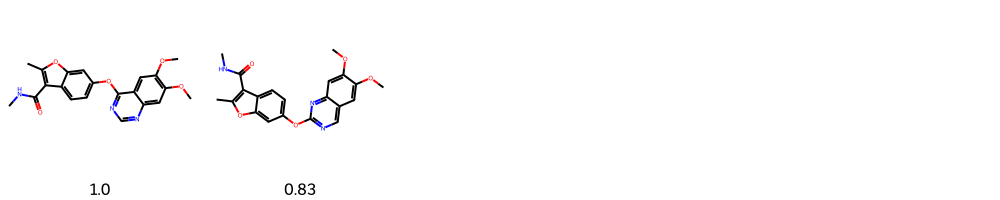

In [4]:
unique_valid_smiles_0p05_1 = gen_mol(smiles_str, coati_version = 1, num_variations = 100, noise_scale = 0.05)

### 100 generations using COATI2 with a noise of 0.05

Attempted 100 COATI2 generations with a noise scale of 0.05 and generated 1 unique structures.


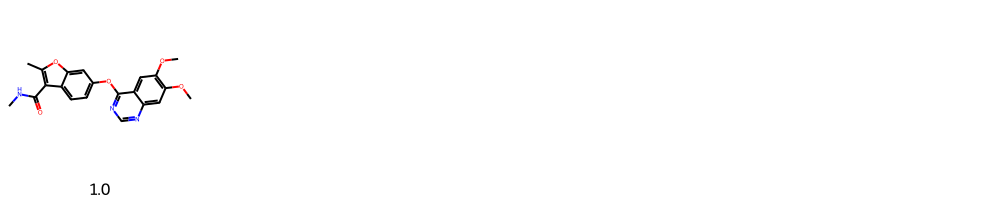

In [5]:
unique_valid_smiles_0p05_2 = gen_mol(smiles_str, coati_version = 2, num_variations = 100, noise_scale = 0.05)

### 100 generations using COATI1 with a noise of 0.15

Attempted 100 COATI1 generations with a noise scale of 0.15 and generated 4 unique structures.


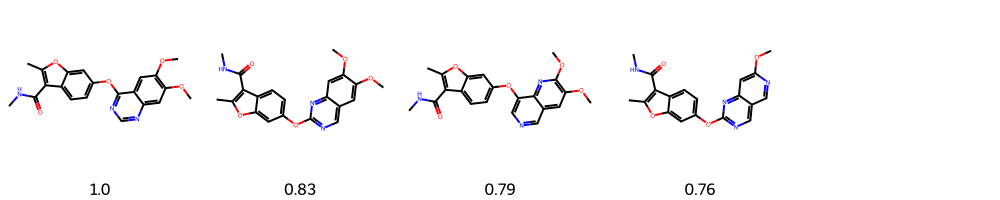

In [6]:
unique_valid_smiles_0p15_1 = gen_mol(smiles_str, coati_version = 1, num_variations = 100, noise_scale = 0.15)

### 100 generations using COATI2 with a noise of 0.15

Attempted 100 COATI2 generations with a noise scale of 0.15 and generated 2 unique structures.


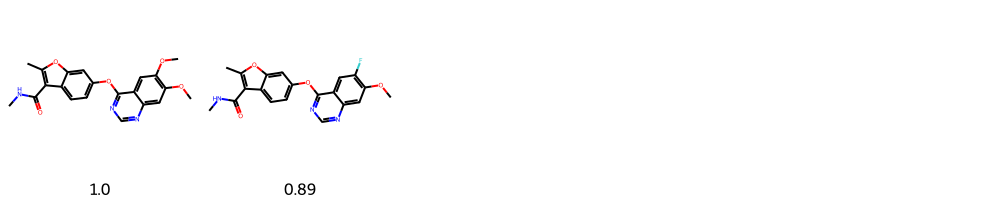

In [7]:
unique_valid_smiles_0p15_2 = gen_mol(smiles_str, coati_version = 2, num_variations = 100, noise_scale = 0.15)

### 100 generations using COATI1 with a noise of 0.25

Attempted 100 COATI1 generations with a noise scale of 0.25 and generated 9 unique structures.


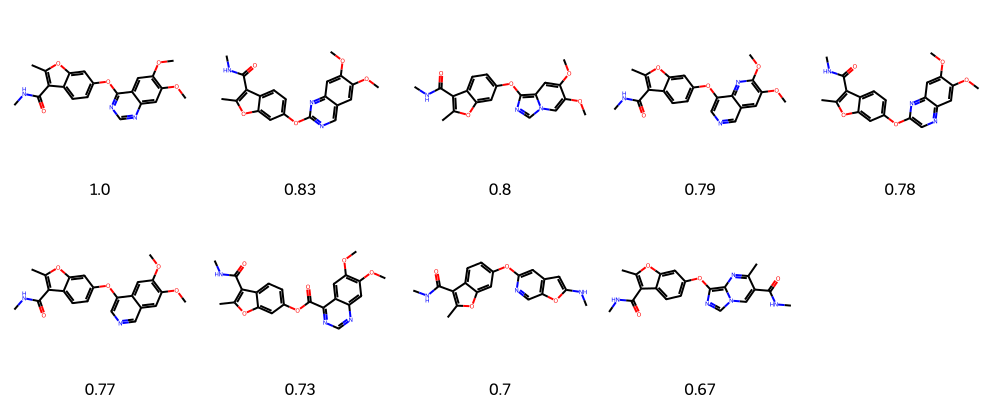

In [8]:
unique_valid_smiles_0p25_1 = gen_mol(smiles_str, coati_version = 1, num_variations = 100, noise_scale = 0.25)

### 100 generations using COATI2 with a noise of 0.25

Attempted 100 COATI2 generations with a noise scale of 0.25 and generated 9 unique structures.


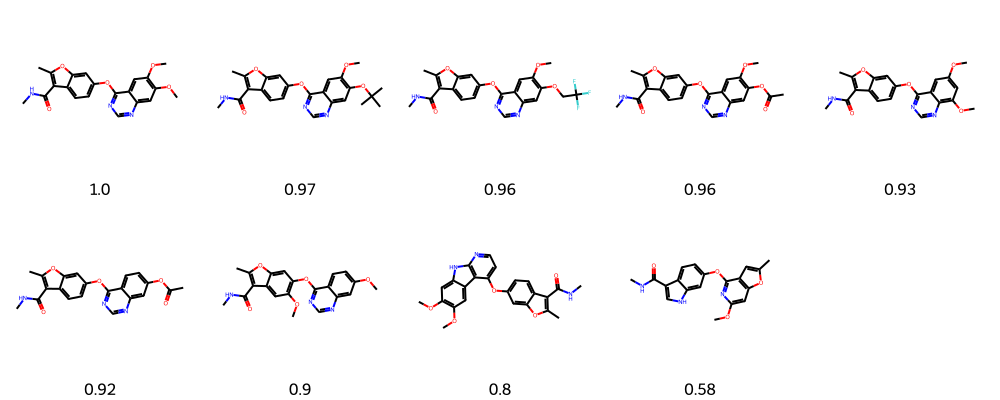

In [9]:
unique_valid_smiles_0p25_2 = gen_mol(smiles_str, coati_version = 2, num_variations = 100, noise_scale = 0.25)

### 100 generations using COATI1 with a noise of 0.5

Attempted 100 COATI1 generations with a noise scale of 0.5 and generated 65 unique structures.


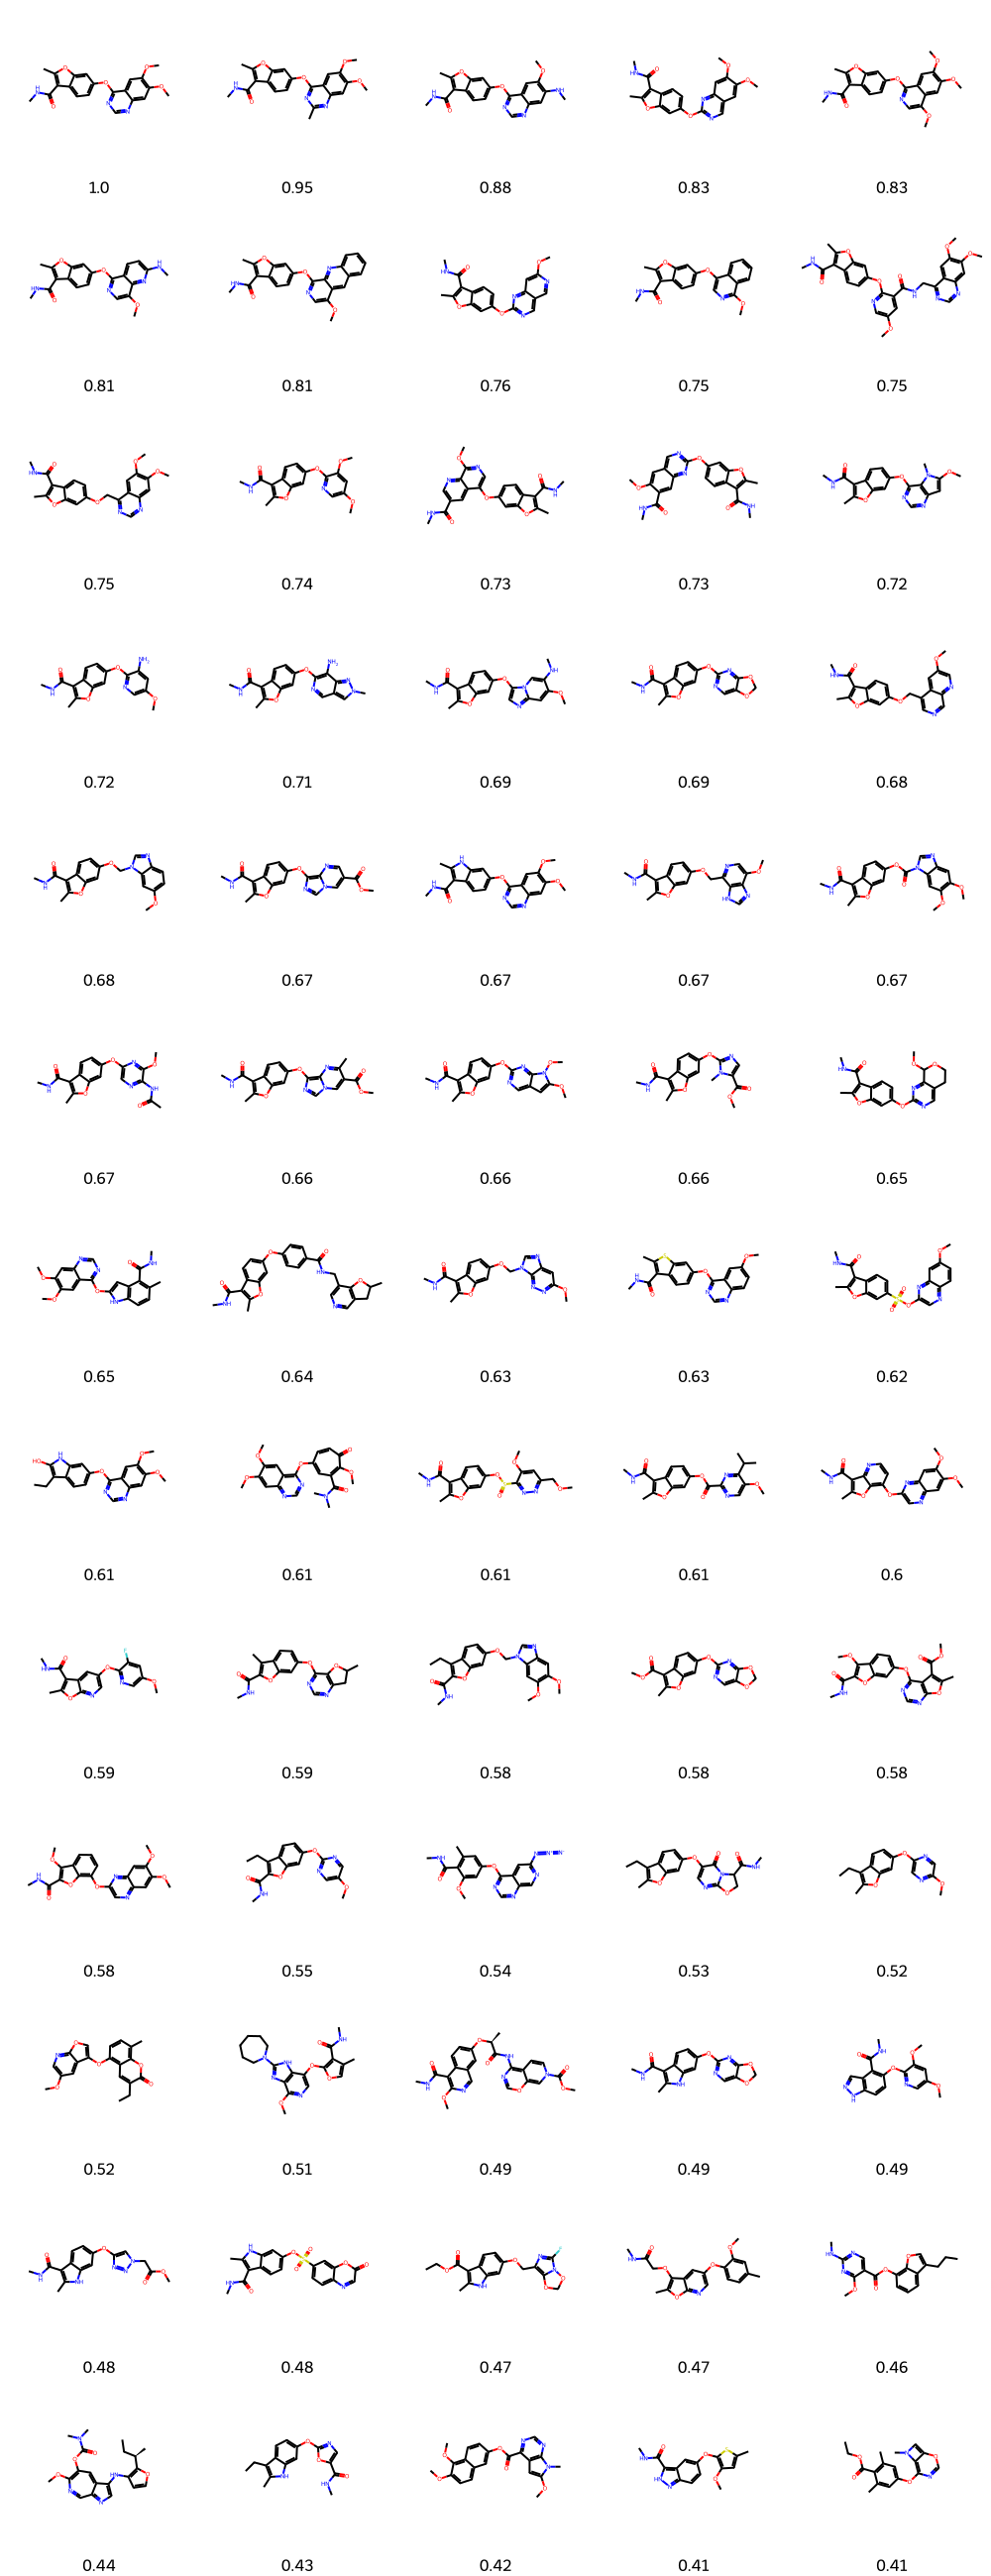

In [10]:
unique_valid_smiles_0p5_1 = gen_mol(smiles_str, coati_version = 1, num_variations = 100, noise_scale = 0.5)

### 100 generations using COATI2 with a noise of 0.5

Attempted 100 COATI2 generations with a noise scale of 0.5 and generated 37 unique structures.


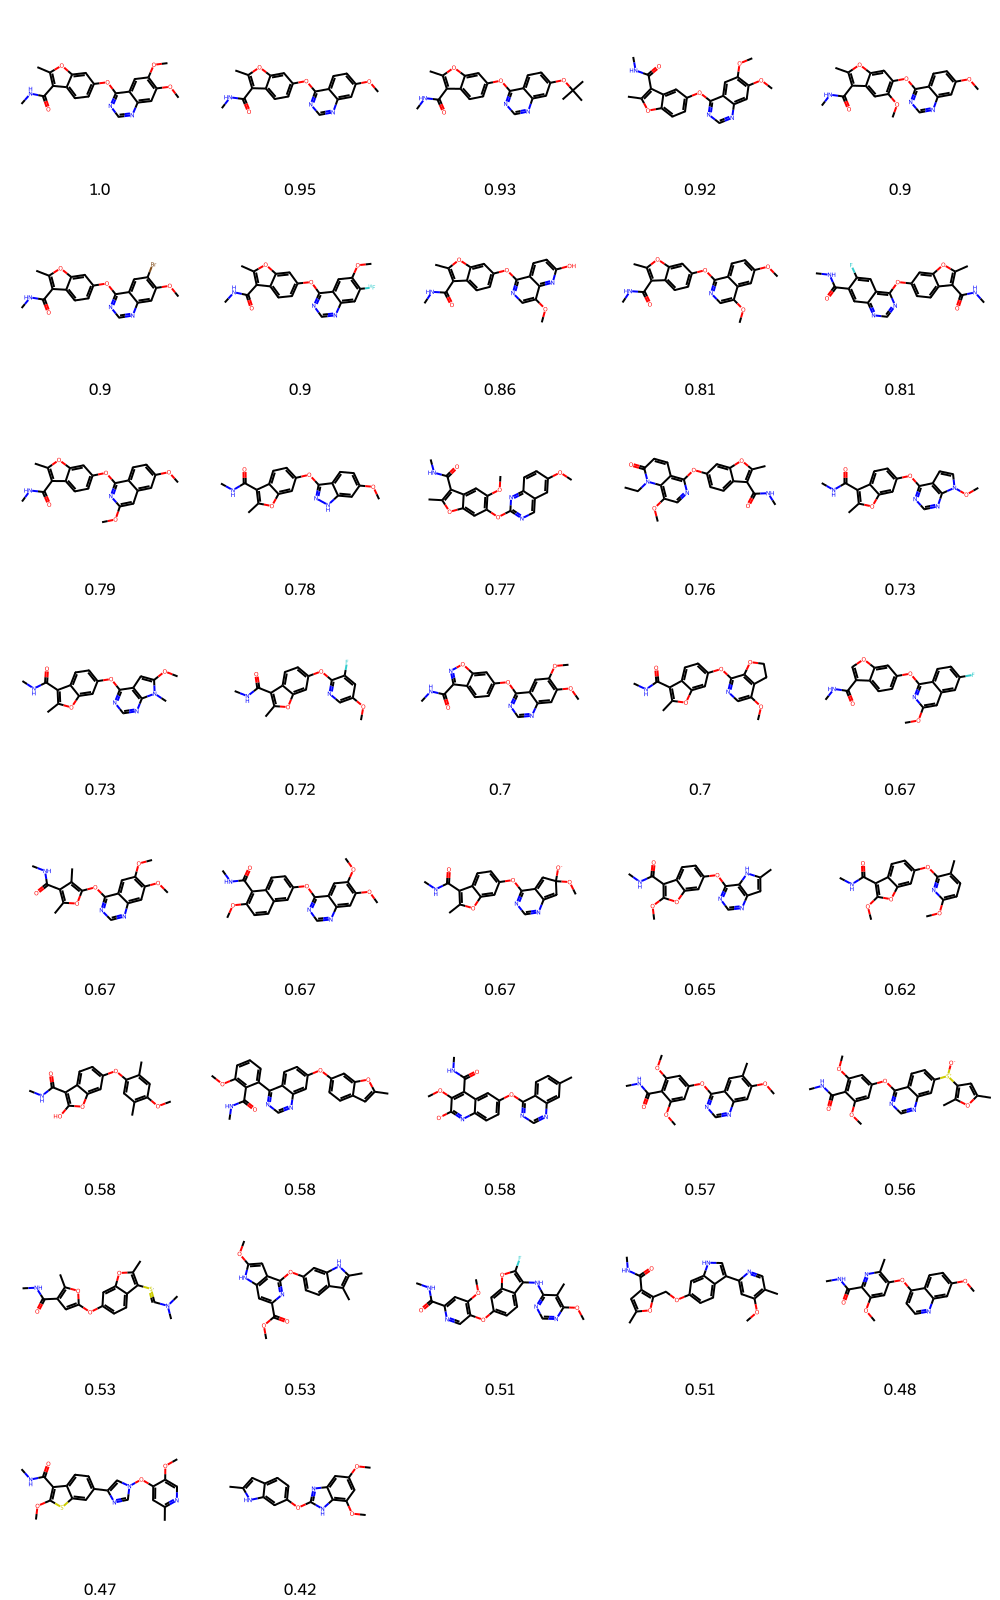

In [11]:
unique_valid_smiles_0p5_2 = gen_mol(smiles_str, coati_version = 2, num_variations = 100, noise_scale = 0.5)